In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from google.protobuf import text_format
import matplotlib.pyplot as plt

In [3]:
# Check to see if there are any GPUs
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
# Reading the file
df = pd.read_csv('cardio_train.csv', sep=';')
df=resample(df, n_samples=5000)

# Drop id column
df=df.drop('id', axis=1)
# Converting age from in-days to in-years
df['age']=df['age']/365

In [5]:
# Preparing Train and Test Datasets

X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

In [6]:
# Standardize data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Use a multi-GPU strategy to reduce training time (if there are GPUs available)

strategy = tf.distribute.MirroredStrategy()
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
# Converting pandas datasets to tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.with_options(options)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.with_options(options)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [11]:
# Defining the neural network model

tf.random.set_seed(42)


with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])



    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007),
#         optimizer = tf.keras.optimizers.Adam(clr),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)


Epoch 1/1000
160/160 [==============================] - 11s 27ms/step - loss: 0.7437 - accuracy: 0.6350 - precision: 0.6474 - recall: 0.6206 - val_loss: 1.2057 - val_accuracy: 0.5190 - val_precision: 0.5127 - val_recall: 0.9624
Epoch 2/1000
160/160 [==============================] - 2s 14ms/step - loss: 0.8922 - accuracy: 0.6513 - precision: 0.6628 - recall: 0.6403 - val_loss: 0.7248 - val_accuracy: 0.5870 - val_precision: 0.5567 - val_recall: 0.8950
Epoch 3/1000
160/160 [==============================] - 3s 16ms/step - loss: 0.8029 - accuracy: 0.6622 - precision: 0.6726 - recall: 0.6550 - val_loss: 0.6148 - val_accuracy: 0.6570 - val_precision: 0.6198 - val_recall: 0.8297
Epoch 4/1000
160/160 [==============================] - 2s 15ms/step - loss: 0.7416 - accuracy: 0.6737 - precision: 0.6868 - recall: 0.6595 - val_loss: 0.6112 - val_accuracy: 0.6540 - val_precision: 0.6206 - val_recall: 0.8099
Epoch 5/1000
160/160 [==============================] - 2s 15ms/step - loss: 0.6257 - accur

In [12]:
# Saving the model

model.save('cardio_model.h5')

In [13]:
# Loading the mode

model = keras.models.load_model('cardio_model.h5')

In [14]:
# Plotting the learning process

def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

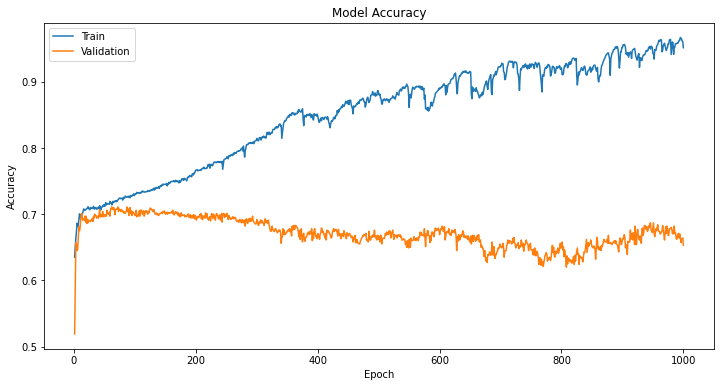

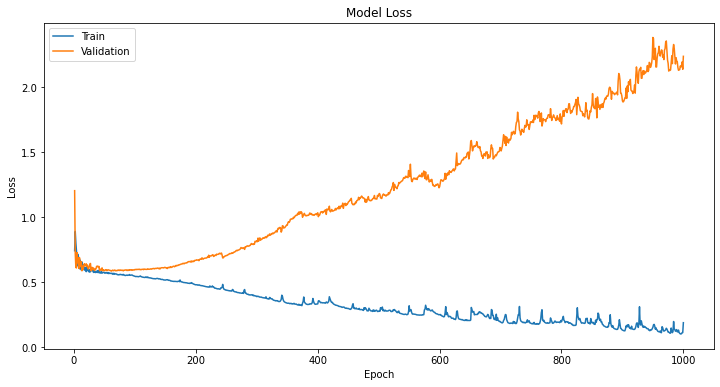

In [15]:
plotLearningCurve(history,1000)

In [ ]:
# Using the model to make prediction

i=0
while i<100:
    height=input("Enter Your height in cm: ")
    gender=input("Enter your gender with f for female and m for male: ")
    if gender=='f':
        gender=2
    else:
        gender=1
    weight=input('Enter you weight in kg: ')
    lo_pressure=input('Enter your high (systolic) pressure: ')
    hi_pressure=input('Enter your low (diastolic) pressure: ')
    choles=input('Is your blood cholestrol high? y for Yes and and n for No')
    if choles=='y':
                 choles=1
    else:
                 choles=0
    gluc=input('Is your blood sugar high? y for Yes and and n for No')
    if gluc =='y':
        gluc=1
    else:
        gluc=0
    if gluc is not str:
        raise Exception('Your answer should be either y or n')
    smok=input("Do you smoke regularly? (at least 5 a week) y for Yes and and 'n' for No")
    if smok =='y':
        smok=1
    else:
        smok=0
    if smok is not str:
                        raise Exception('Your answer should be either y or n')

    alc=input('Do you consume alcohol? (at least three glasses of beer or two shots of vodka a week) y for Yes and and n for No')
    if alc =='y':
        alc=1
    else:
        alc=0
    if alc is not str:
                    raise Exception('Your answer should be either y or n')

    excer=input('Do you excercise? ( at least 60 minutes of moderate running a week )y for Yes and and n for No')
    if excer =='y':
        excer=1
    else:
        excer=0
    if excer is not str:
                    raise Exception('Your answer should be either y or n')
                    
    age=input('Enter your age in years: ')
    if age >120:
                    raise Exception('Your seem to be making a mistake')
    i+=1
    df2=np.array([height, gender, weight, lo_pressure, hi_pressure, choles, gluc, smok, alc, excer, age])
    sample = [eval(x) for x in df2]
    sample=np.array(sample)
    
    if model.predict(sample.reshape(1,-1)) ==1:
        print("You may have cardiovascular diseases within the next 10 years")
    else:
        print("You are unlikely to have cardiovascular diseases within the next 10 years")
    
    

Enter Your height in cm: 189
